In [1]:
import torch
from torch import nn
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from models.GenClassifier import GenClassifier

from utils.visualize import show_img, plot_loss_history, show_samples, plot_weights, plot_gradual_classification_loss, plot_conv_channels
from utils.data_loaders import get_mnist_data_loaders, get_cifar10_data_loaders, get_fashion_mnist_data_loaders
from utils.other import calc_accuracy

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"... Running on {DEVICE} ...")
# BATCH_SIZE = 32
BATCH_SIZE = 16

In [3]:
# X_train_loader, X_test_loader, class_names = get_mnist_data_loaders(batch_size=BATCH_SIZE, root_path="data/", download=False)
# X_train_loader, X_test_loader, class_names = get_cifar10_data_loaders(batch_size=BATCH_SIZE, root_path="data/", download=False)
X_train_loader, X_test_loader, class_names = get_fashion_mnist_data_loaders(batch_size=BATCH_SIZE, root_path="data/", download=False)

In [ ]:
config_dict = {
  "classifier_cnn_layers": (32,64,4),
  "classifier_cnn_input_dims": (28,28,1),
  "classifier_cnn_output_dim": 144,
  "classifier_head_layers": (64,128,10),
  "generator_cnn_block_in_layer_shapes": (144,240),
  "generator_prediction_in_layer_shapes": (10,72),
  "generator_in_combined_main_layer_shapes": (312,512,288),
  "generator_trans_cnn_input_dims":(2,12,12),
  "generator_cnn_trans_layer_shapes": (32,64,32,1),
  "classifier_lr": 0.0008,
  "classifier_weight_decay": 1e-5,
  "generator_reconstruction_loss_importance": 1.2,
  "generator_reconstruction_from_no_z_loss_importance": 1.2,
  "generator_classification_loss_importance": 0.6,
  "generator_z_similarity_loss_importance": 1.0,
  "generator_contrastive_loss_importance": 0.8,
  "generator_lr": 0.001,
  "generator_weight_decay": 1e-5,
  "eval_run_classifier_cnn_block_optimizer_lr": 0.008,
  "eval_run_classifier_cnn_block_optimizer_weight_decay": 1e-5,
  "eval_run_classifier_head_block_optimizer_lr": 0.015,
  "eval_run_classifier_head_block_optimizer_weight_decay": 1e-5,
  "device": DEVICE
}

model = GenClassifier(config_dict=config_dict)
model.load_pretrained_params("model_parameters/fashion_mnist_23-1-2022_11.27.tar", load_optimizers=True)

### Evaluate classification improvement from using generator

In [6]:
def eval_improvement(max_batches=200, dropout_proba=0.5, num_of_reconstruction_steps=2, norm_cos_similarities=True, cos_similarity_multiplier=5.0):
    model.turn_model_to_mode("eval")
    loss_func_classification = nn.CrossEntropyLoss()
    dropout_func = nn.Dropout(p=dropout_proba)

    history = {
        "accuracy": {"wout_hypotheses_testing":[], "w_hypotheses_testing":[]},
        "loss": {"wout_hypotheses_testing":[], "w_hypotheses_testing":[]}
    }
    cos_sims = y_initial = None
    for i,data in enumerate(X_test_loader):
        if i > max_batches: break
        X, y = [part_of_data.to(DEVICE) for part_of_data in data]
        X_perturbed = dropout_func(X)

        # w/out generative hypotheses testing
        y_hat = model(X_perturbed, hypotheses_testing=False, batch_size=BATCH_SIZE)
        history["accuracy"]["wout_hypotheses_testing"].append(calc_accuracy(y_hat, y))
        history["loss"]["wout_hypotheses_testing"].append(loss_func_classification(y_hat, y).item())

        # w/ generative hypotheses testing
        y_hat = model(
            X_perturbed, hypotheses_testing=True, num_of_reconstruction_steps=num_of_reconstruction_steps,
            batch_size=BATCH_SIZE, norm_cos_similarities=norm_cos_similarities, cos_similarity_multiplier=cos_similarity_multiplier
        )
        history["accuracy"]["w_hypotheses_testing"].append(calc_accuracy(y_hat, y))
        history["loss"]["w_hypotheses_testing"].append(loss_func_classification(y_hat, y).item())

    return(history, y_initial, cos_sims, y)

RESULTS:
-----
Accuracy:
>>> Hypothesis testing improved the accuracy for 367 image batches
>>> Hypothesis testing lowered the accuracy for 38 image batches
>>> On average, the accuracy was improved by 4.87 % (negative = accuracy was lowered, positive = accuracy improved)
Cross-entropy loss:
>>> Hypothesis testing lowered the loss (improved) for 526 image batches
>>> Hypothesis testing made the loss higher for 99 image batches
>>> On average the loss was lowered by 1.031 (negative = loss was added, positive = loss was lowered)



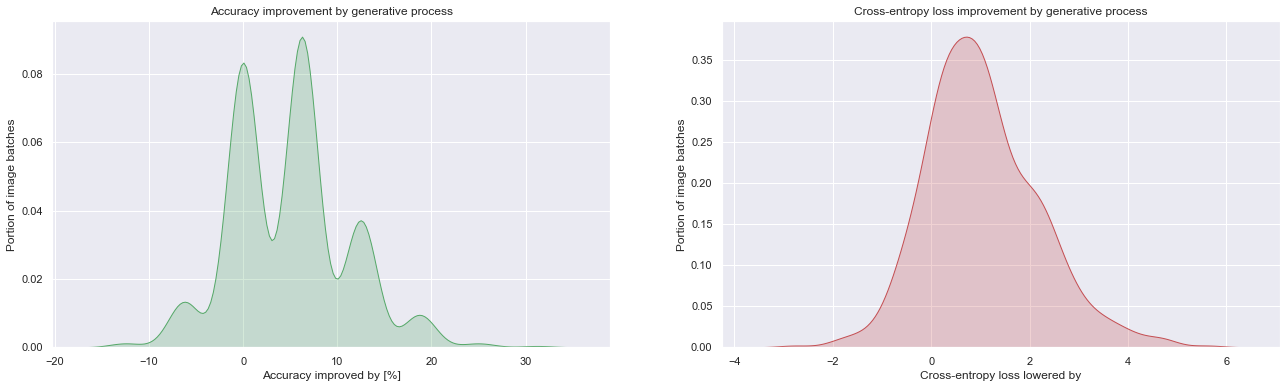

In [8]:
history,y_init,cos_sims,y = eval_improvement(
    max_batches=625,
    dropout_proba=0.5,
    num_of_reconstruction_steps=2,
    norm_cos_similarities=True,
    cos_similarity_multiplier=5.0
)

# Explore how many times the accuracy/loss were improved by the generative hypothesis testing
diff_loss = np.array(history["loss"]["wout_hypotheses_testing"]) - np.array(history["loss"]["w_hypotheses_testing"])
diff_accuracy = np.array(history["accuracy"]["w_hypotheses_testing"]) - np.array(history["accuracy"]["wout_hypotheses_testing"])
print(f"""RESULTS:\n-----
Accuracy:
>>> Hypothesis testing improved the accuracy for {(diff_accuracy > 0).sum()} image batches
>>> Hypothesis testing lowered the accuracy for {(diff_accuracy < 0).sum()} image batches
>>> On average, the accuracy was improved by {round(diff_accuracy.sum() / diff_accuracy.shape[0], 4) * 100} % (negative = accuracy was lowered, positive = accuracy improved)
Cross-entropy loss:
>>> Hypothesis testing lowered the loss (improved) for {(diff_loss > 0).sum()} image batches
>>> Hypothesis testing made the loss higher for {(diff_loss < 0).sum()} image batches
>>> On average the loss was lowered by {round(diff_loss.sum() / diff_loss.shape[0], 4)} (negative = loss was added, positive = loss was lowered)
""")

sns.set(style="darkgrid")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
fig = sns.kdeplot(diff_accuracy*100, shade=True, color="g", ax=ax[0])
ax[0].set_ylabel("Portion of image batches")
ax[0].set_xlabel("Accuracy improved by [%]")
ax[0].set_title("Accuracy improvement by generative process")
fig = sns.kdeplot(diff_loss, shade=True, color="r", ax=ax[1])
ax[1].set_ylabel("Portion of image batches")
ax[1].set_xlabel("Cross-entropy loss lowered by")
ax[1].set_title("Cross-entropy loss improvement by generative process")
plt.show()

### Show generator's learned categories

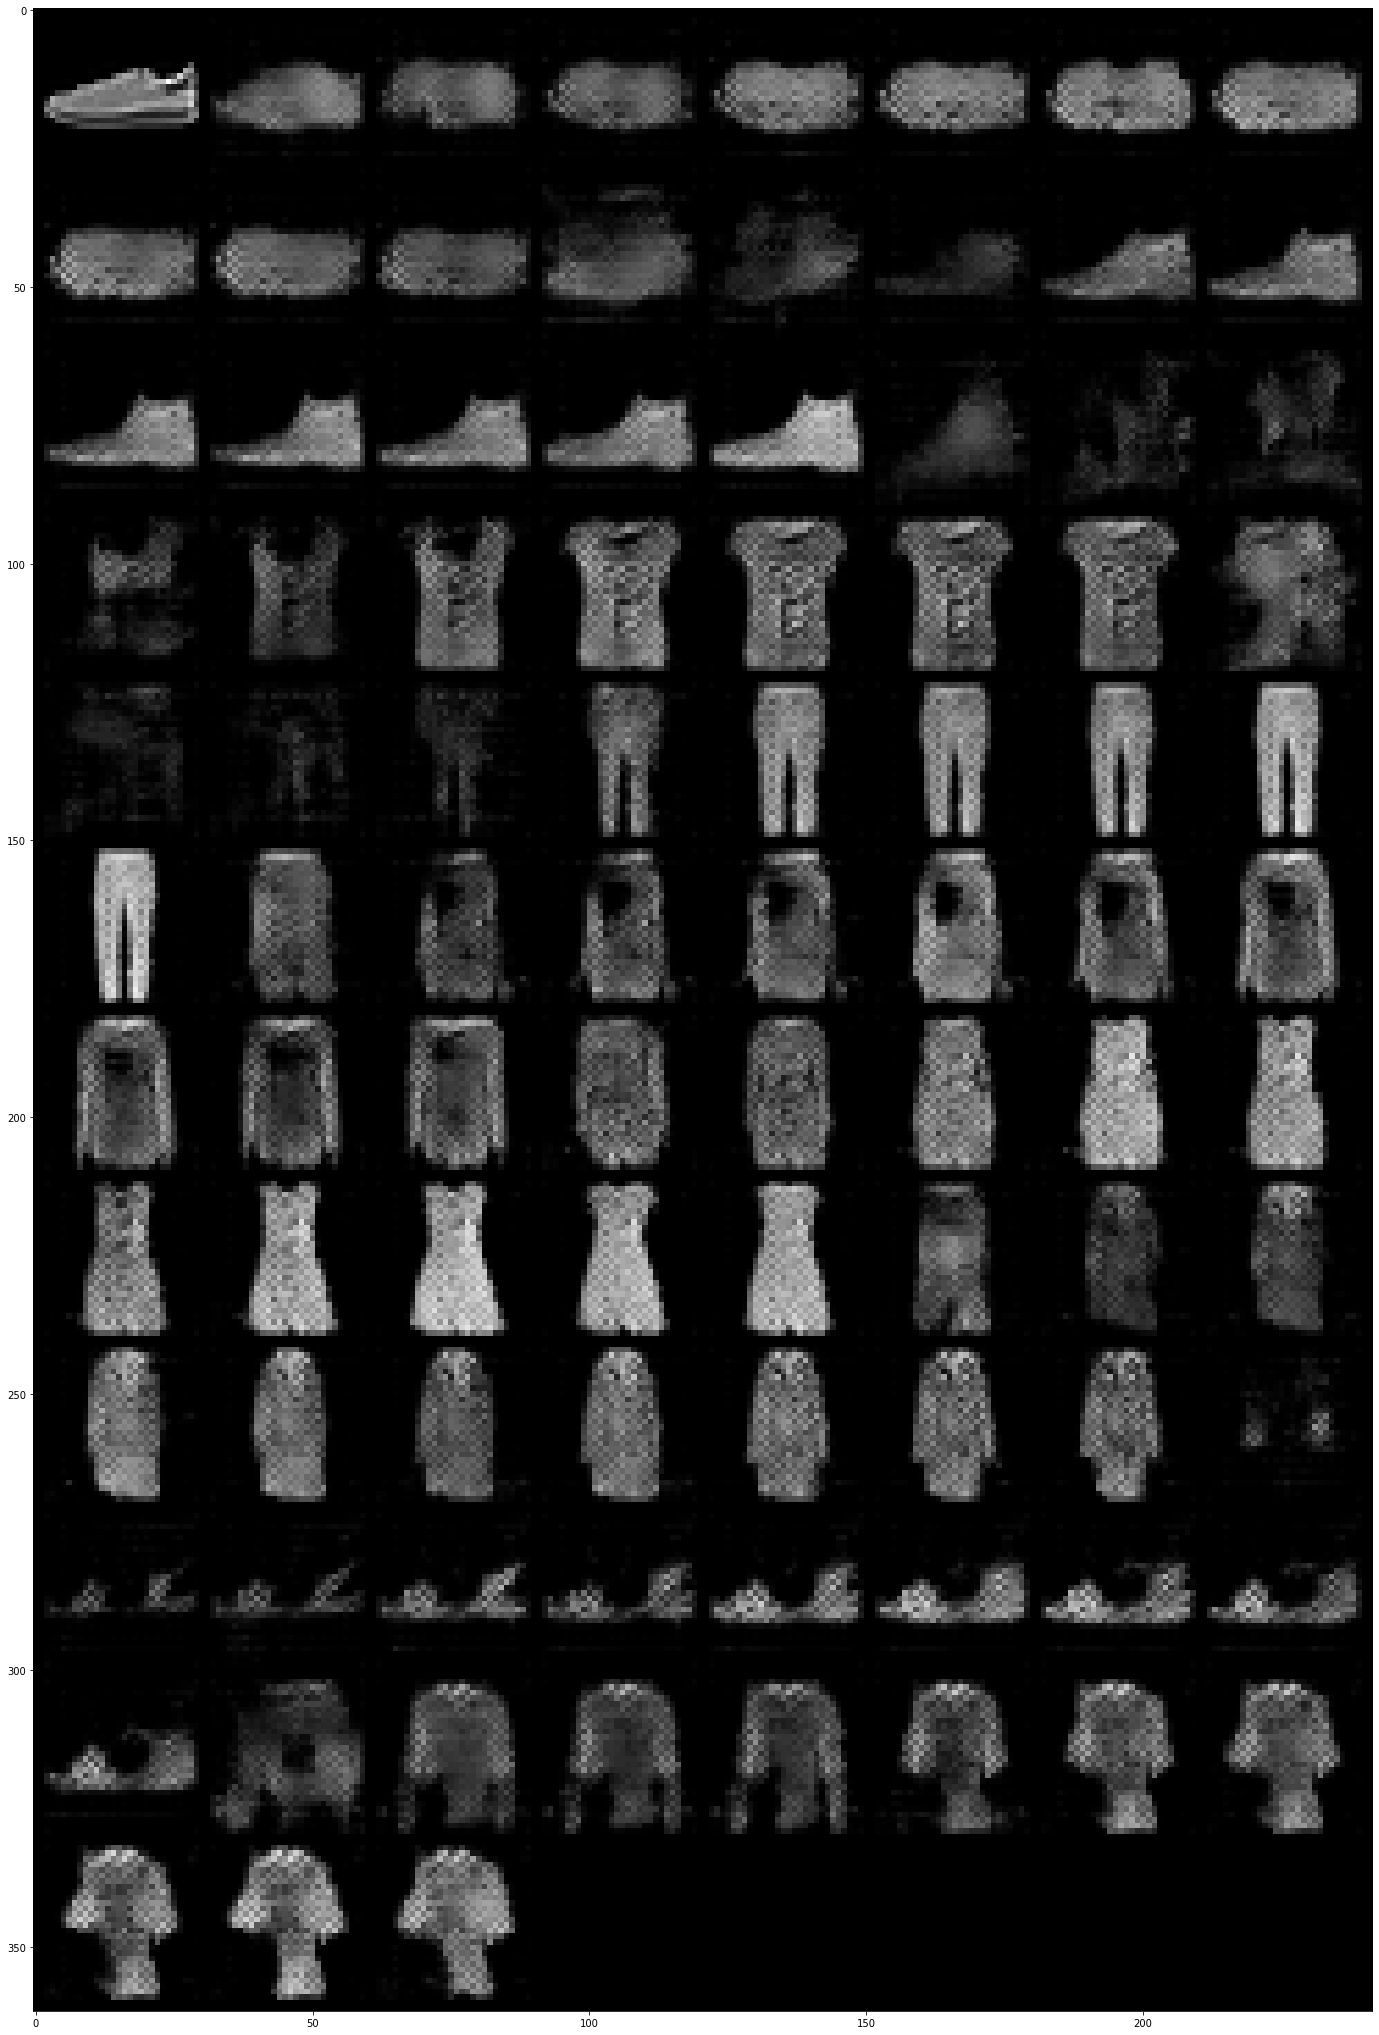

In [5]:
data = next(iter(X_train_loader))
X, y = data[0].to(model.config_dict["device"]), data[1].to(model.config_dict["device"])

z = model.classifier["cnn_block"](X[0].expand(1,-1,-1,-1))
z = z.reshape((1, model.config_dict["classifier_cnn_output_dim"]))
y_hat = model.classifier["head_block"](z)

to_show = X[0].cpu()[:,None,:,:]
for different_y in range(1,model.config_dict["classifier_head_layers"][-1]):
    for reconstruct_step_i in range(10):
        different_y_onehot = nn.functional.one_hot(torch.tensor([(y[0].item() + different_y) % 10]), 10).float().to(model.config_dict["device"])
        h = model.generator["head_block"](z.detach(), different_y_onehot)
        h_reshaped_for_cnn_block = torch.reshape(h, (1, *model.config_dict["generator_trans_cnn_input_dims"]))
        X_hat = model.generator["trans_cnn_block"](h_reshaped_for_cnn_block)
        z = model.classifier["cnn_block"](X_hat[0].detach().expand(1,-1,-1,-1)).reshape((1, model.config_dict["classifier_cnn_output_dim"]))
        to_show = torch.cat((to_show, X_hat[0].detach().cpu()[:,None,:,:]))

grid = torchvision.utils.make_grid(to_show, nrow=8)
plt.figure(figsize=(24,(to_show.shape[0]//8)*4))
plt.imshow(grid.permute(1, 2, 0))